In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [139]:
trajectory_results = pd.read_csv('Eco_Traj.txt', delimiter='\t')
trajectory_results.head()

,simulation_time,section_id,veh_type_id,numberLane,vehicle_id,distance2End,CurrentSpeed
0,59.2,1252,5380,1,22,180.1970,53.6246
1,59.2,1252,154,1,25,91.3649,48.8423
2,59.2,1252,154,2,24,150.3190,56.6055
3,59.2,1249,5380,1,3,238.3130,60.9077
4,60.0,1252,5380,1,22,192.1150,53.6295


In [140]:
trajectory_results.vehicle_id.nunique()

4221

In [141]:
trajectory_results[trajectory_results.veh_type_id==154].vehicle_id.nunique()

2120

In [142]:
filter_trajctory_by_time = trajectory_results[trajectory_results['simulation_time'].between(4100, 4500)]
filter_trajctory_by_time.head()

,simulation_time,section_id,veh_type_id,numberLane,vehicle_id,distance2End,CurrentSpeed
180723,4100.0,1252,154,1,2204,174.43800,59.7256
180724,4100.0,1252,154,1,2209,129.25400,52.1088
180725,4100.0,1252,154,1,2213,102.93400,50.0610
180726,4100.0,1252,154,2,2219,80.60030,56.9977
180727,4100.0,1249,5380,1,2199,2.88648,0.0000


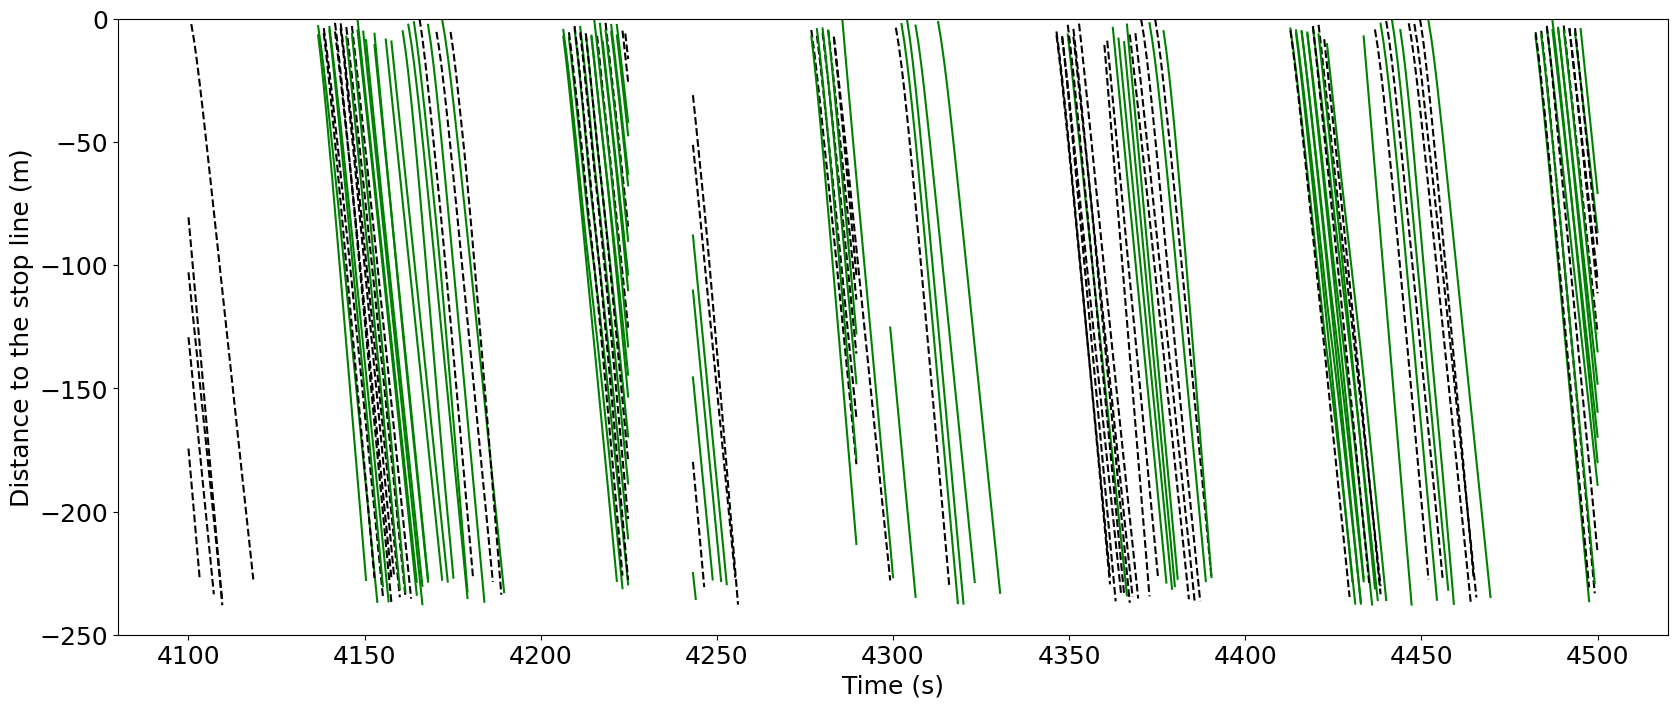

In [152]:
vehicle_id = filter_trajctory_by_time.vehicle_id.unique()
control_vehicle_id = 5380
non_control_vehicle_id = 154
section_id = [1252]

plt.figure(figsize=(20,8))
for veh_id in vehicle_id:
    veh_id_df = filter_trajctory_by_time[filter_trajctory_by_time.vehicle_id == veh_id].sort_values('simulation_time')
    veh_id_df = veh_id_df[veh_id_df['section_id'].isin(section_id)]
    veh_id_df = veh_id_df[veh_id_df['numberLane'].isin([1,2])]

    # veh_id_trajectory = veh_id_df.CurrentSpeed
    distance2End = veh_id_df['distance2End'] * -1
    time = veh_id_df['simulation_time']
    if control_vehicle_id in veh_id_df['veh_type_id'].unique():
        color = 'g'
    else:
        color = 'k--'

    plt.plot(time, distance2End, color)
    plt.ylim((-250, 0))
    plt.xlabel('Time (s)', fontdict={'size':18, 'color':'black'})
    plt.ylabel('Distance to the stop line (m)', fontdict={'size': 18})
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)

In [123]:
if 5380 in veh_id_df.veh_type_id.unique():
    print('True')